In [1]:
import pickle

import sys
sys.path.insert(0, 'src') 
sys.path.insert(0, '/data/ch52669/gene_interaction/tot-gene-sets/MedAgents') 
import os
import json
from functools import partial

In [2]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

In [3]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [4]:
def getSentenceEmbedding(sentence, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    # Perform pooling. In this case, mean pooling.
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embedding

In [5]:
def similarity_score(pred, label):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    label_embedding = all_go_terms_embeddings_dict[label]
    similarity_score = cosine_similarity(pred_embedding, label_embedding)[0][0]
    return similarity_score

def similarity_percentile(similarity_score, pred):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    null_dist = []
    for term in all_go_terms_embeddings_dict.keys():
        term_embedding = all_go_terms_embeddings_dict[term]
        sentenceSim = cosine_similarity(pred_embedding, term_embedding)[0][0]
        null_dist.append(sentenceSim)
    # get similarity percentile
    null_dist = np.array(null_dist)
    # return the fraction of scores that are smaller than the candidate
    percentile = (null_dist < similarity_score).mean()
    return percentile

In [6]:
all_go_terms_embeddings_dict = pickle.load(open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'rb'))

In [7]:
all_go_terms_embeddings_dict.keys()

dict_keys(['tricuspid valve morphogenesis', 'angiogenesis', 'cellular response to nutrient', 'acrosome assembly', 'musculoskeletal movement, spinal reflex action', 'atrioventricular valve development', 'tryptophanyl-tRNA aminoacylation', 'cellular response to mineralocorticoid stimulus', 'detection of chemical stimulus involved in sensory perception of smell', 'membrane lipid metabolic process', 'negative regulation of bone remodeling', 'purine nucleotide catabolic process', 'regulation of kidney size', 'relaxation of muscle', 'endocrine system development', 'regulation of triglyceride metabolic process', 'excitatory synapse assembly', 'regulation of DNA catabolic process', 'embryonic heart tube left/right pattern formation', 'medium-chain fatty acid transport', 'cyclic nucleotide transport', 'pronephric nephron tubule development', 'methionine transport', 'positive regulation of RNA biosynthetic process', 'regulation of protein export from nucleus', 'protein acetylation', 'rRNA import

In [10]:
# x = tot_results[12]
# x = t['steps']['steps'][0]['x']
# y = t['label']
# x = ', '.join(x.split(' '))
# enriched_terms = gp.profile(organism='hsapiens', query=x)
# print(x)
# enriched_terms

In [17]:
## from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)
from tqdm import tqdm_notebook

not_found = 0
with open('results2/cot_eval.pkl', 'rb') as f:
    tot_results = pickle.load(f)
    
results = []
for i, t in enumerate(tqdm_notebook(tot_results)):
#     print(i,t)
    x = t['x'] #t['steps']['steps'][0]['x']
    y = t['y_true']#['label']
    x = ', '.join(x.split(' '))
    
    enriched_terms = gp.profile(organism='hsapiens', query=x)
    
    if len(enriched_terms) == 0:
        not_found +=1
        print(i)
        result_dict = {'x':x, 'y':y, 'pred_y':'not found', 'sim':0, 'percentile': 0}
        results.append(result_dict)
    else:
        # Find the index of the smallest value in 'Column_Name'
        min_value_index = enriched_terms['p_value'].idxmin()

    #     print(enriched_terms.loc[min_value_index]['name'])
        # Retrieve the row with the smallest value
        pred_y = enriched_terms.loc[min_value_index]['name']
    #     pred_y = enriched_terms[enriched_terms.p_value == enriched_terms.p_value.min()].name.item()

        sim = similarity_score(pred_y, y)
        percentile = similarity_percentile(sim, pred_y)
        result_dict = {'x':x, 'y':y, 'pred_y':pred_y, 'sim':sim, 'percentile': percentile}
        results.append(result_dict)
print(not_found)

/tmp/ipykernel_475631/4056422715.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, t in enumerate(tqdm_notebook(tot_results)):


  0%|          | 0/100 [00:00<?, ?it/s]

12
15
16
17
22
25
30
37
42
43
47
48
57
58
60
62
66
67
68
71
72
74
87
95
97
25


In [18]:
lst = [12, 15, 16, 17, 21, 24, 29, 36, 41, 42, 46, 47]

In [19]:
with open('gsea_eval.pkl', 'wb') as f:
    pickle.dump(results, f)

In [20]:
len(results)

100

In [24]:
th = []
for r in results:
    if r['percentile'] > 0.99:
        th.append(1)
    else:
        th.append(0)
sum(th)/len(th)

0.17

sim
count 100
mean 0.2372

quatile_sim
count 100
mean 0.4976

filtered_sim
count 88
mean 0.2478

filtered_quatile_sim
count 88
mean 0.52


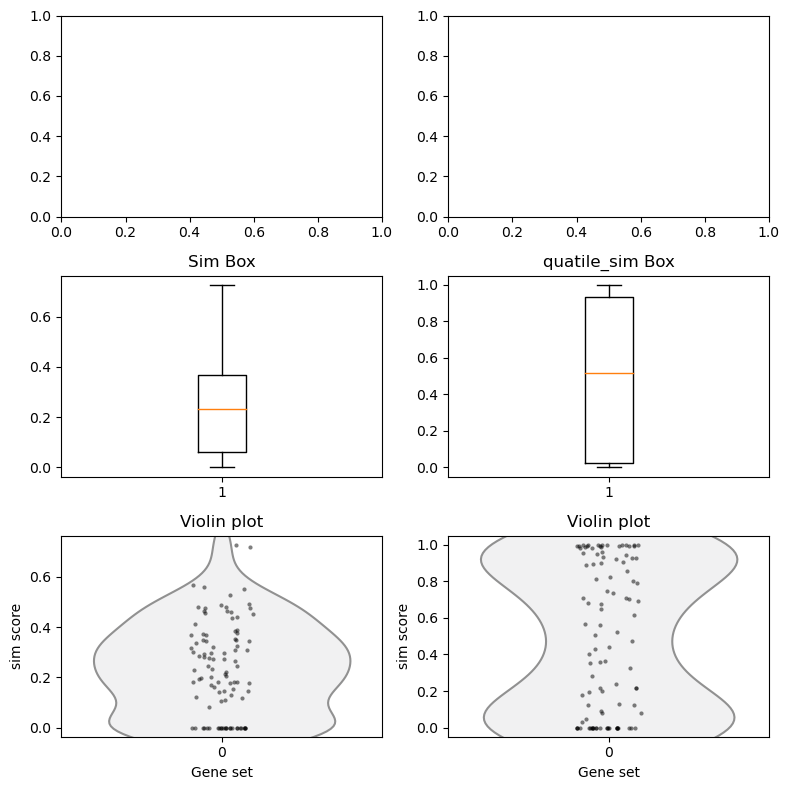

In [22]:
filtered_sim = []
filtered_quatile_sim = []

sim = []
quatile_sim = []

for i, r in enumerate(results):
    sim.append(r['sim'])
    quatile_sim.append(r['percentile'])
    if i not in lst:
        filtered_sim.append(r['sim'])
        filtered_quatile_sim.append(r['percentile'])

print('sim')
print('count', len(sim))
print('mean', round(sum(sim)/len(sim),4))

print('')
print('quatile_sim')
print('count', len(quatile_sim))
print('mean', round(sum(quatile_sim)/len(quatile_sim),4))

print('')
print('filtered_sim')
print('count', len(filtered_sim))
print('mean', round(sum(filtered_sim)/len(filtered_sim),4))

print('')
print('filtered_quatile_sim')
print('count', len(filtered_quatile_sim))
print('mean', round(sum(filtered_quatile_sim)/len(filtered_quatile_sim),4))

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

# # Upper Left: Histogram 1
# axs[0, 0].hist(sim, color='blue', alpha=0.7)
# axs[0, 0].set_title('Sim Hist')

# # Upper Right: Histogram 2
# axs[0, 1].hist(final_sim, color='orange', alpha=0.7)
# axs[0, 1].set_title('Pred Sim Hist')

# Lower Left: Box Plot 1
axs[1, 0].boxplot(sim)
axs[1, 0].set_title('Sim Box')

# Lower Right: Box Plot 2
axs[1, 1].boxplot(quatile_sim)
axs[1, 1].set_title('quatile_sim Box')

# Violin plot with individual data points in the first subplot
sns.violinplot(ax=axs[2, 0], data=sim, inner=None, palette="light:b")  # 'inner=None' removes the inner bars inside the violins
sns.stripplot(ax=axs[2, 0], data=sim, color='k', size=3, jitter=True, alpha=0.5)
axs[2, 0].set_title('Violin plot')
axs[2, 0].set_xlabel('Gene set')
axs[2, 0].set_ylabel('sim score')


# Violin plot with individual data points in the first subplot
sns.violinplot(ax=axs[2, 1], data=quatile_sim, inner=None, palette="light:b")  # 'inner=None' removes the inner bars inside the violins
sns.stripplot(ax=axs[2, 1], data=quatile_sim, color='k', size=3, jitter=True, alpha=0.5)
axs[2, 1].set_title('Violin plot')
axs[2, 1].set_xlabel('Gene set')
axs[2, 1].set_ylabel('sim score')


# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

sim
count 100
mean 0.237

quatile_sim
count 100
mean 0.498

filtered_sim
count 88
mean 0.248

filtered_quatile_sim
count 88
mean 0.52


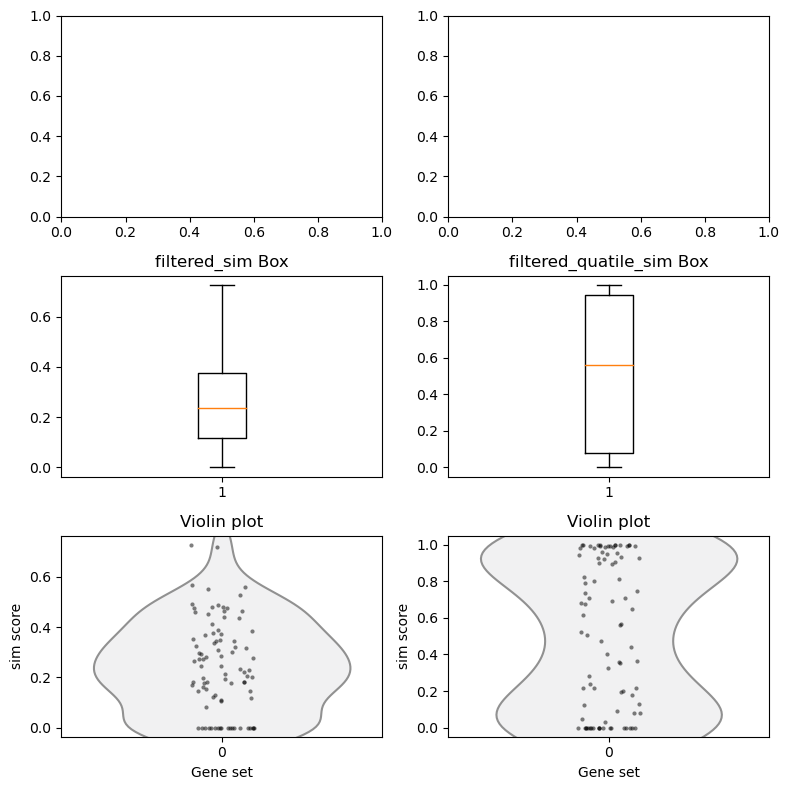

In [23]:
filtered_sim = []
filtered_quatile_sim = []

sim = []
quatile_sim = []

for i, r in enumerate(results):
    sim.append(r['sim'])
    quatile_sim.append(r['percentile'])
    if i not in lst:
        filtered_sim.append(r['sim'])
        filtered_quatile_sim.append(r['percentile'])

print('sim')
print('count', len(sim))
print('mean', round(sum(sim)/len(sim),3))

print('')
print('quatile_sim')
print('count', len(quatile_sim))
print('mean', round(sum(quatile_sim)/len(quatile_sim),3))

print('')
print('filtered_sim')
print('count', len(filtered_sim))
print('mean', round(sum(filtered_sim)/len(filtered_sim),3))

print('')
print('filtered_quatile_sim')
print('count', len(filtered_quatile_sim))
print('mean', round(sum(filtered_quatile_sim)/len(filtered_quatile_sim),3))

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

# # Upper Left: Histogram 1
# axs[0, 0].hist(sim, color='blue', alpha=0.7)
# axs[0, 0].set_title('Sim Hist')

# # Upper Right: Histogram 2
# axs[0, 1].hist(final_sim, color='orange', alpha=0.7)
# axs[0, 1].set_title('Pred Sim Hist')

# Lower Left: Box Plot 1
axs[1, 0].boxplot(filtered_sim)
axs[1, 0].set_title('filtered_sim Box')

# Lower Right: Box Plot 2
axs[1, 1].boxplot(filtered_quatile_sim)
axs[1, 1].set_title('filtered_quatile_sim Box')

# Violin plot with individual data points in the first subplot
sns.violinplot(ax=axs[2, 0], data=filtered_sim, inner=None, palette="light:b")  # 'inner=None' removes the inner bars inside the violins
sns.stripplot(ax=axs[2, 0], data=filtered_sim, color='k', size=3, jitter=True, alpha=0.5)
axs[2, 0].set_title('Violin plot')
axs[2, 0].set_xlabel('Gene set')
axs[2, 0].set_ylabel('sim score')


# Violin plot with individual data points in the first subplot
sns.violinplot(ax=axs[2, 1], data=filtered_quatile_sim, inner=None, palette="light:b")  # 'inner=None' removes the inner bars inside the violins
sns.stripplot(ax=axs[2, 1], data=filtered_quatile_sim, color='k', size=3, jitter=True, alpha=0.5)
axs[2, 1].set_title('Violin plot')
axs[2, 1].set_xlabel('Gene set')
axs[2, 1].set_ylabel('sim score')


# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()